In [5]:
import sys
sys.path.append("../../src")

In [6]:
import segmentation_models_pytorch as smp
from visualization.model_viz import visualize_training_metrics
from models.utils import load_yaml
from data.train_pipeline import HubMAP_Dataset
import os
import pandas as pd
from visualization.image import display_dataset
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader
import numpy as np
from torchmetrics.functional import dice

In [7]:
BASE_DIR = "D:/Machine_Learning/hubmap-hacking-the-human-vasculature/" 
MODEL_SAVE_PATH = os.path.join(BASE_DIR, "models/unetplusplus/version_0")
CONFIG_PATH = os.path.join(BASE_DIR, "src/models/config/unetplusplsu-0.yaml")
MODEL_PATH = os.path.join(BASE_DIR, "models/unetplusplus/version_0/model-f0-val_dice=0.6339.ckpt")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(MODEL_SAVE_PATH)
print(CONFIG_PATH)
config = load_yaml(CONFIG_PATH)

D:/Machine_Learning/hubmap-hacking-the-human-vasculature/models/unetplusplus/version_0
D:/Machine_Learning/hubmap-hacking-the-human-vasculature/src/models/config/unet.yaml


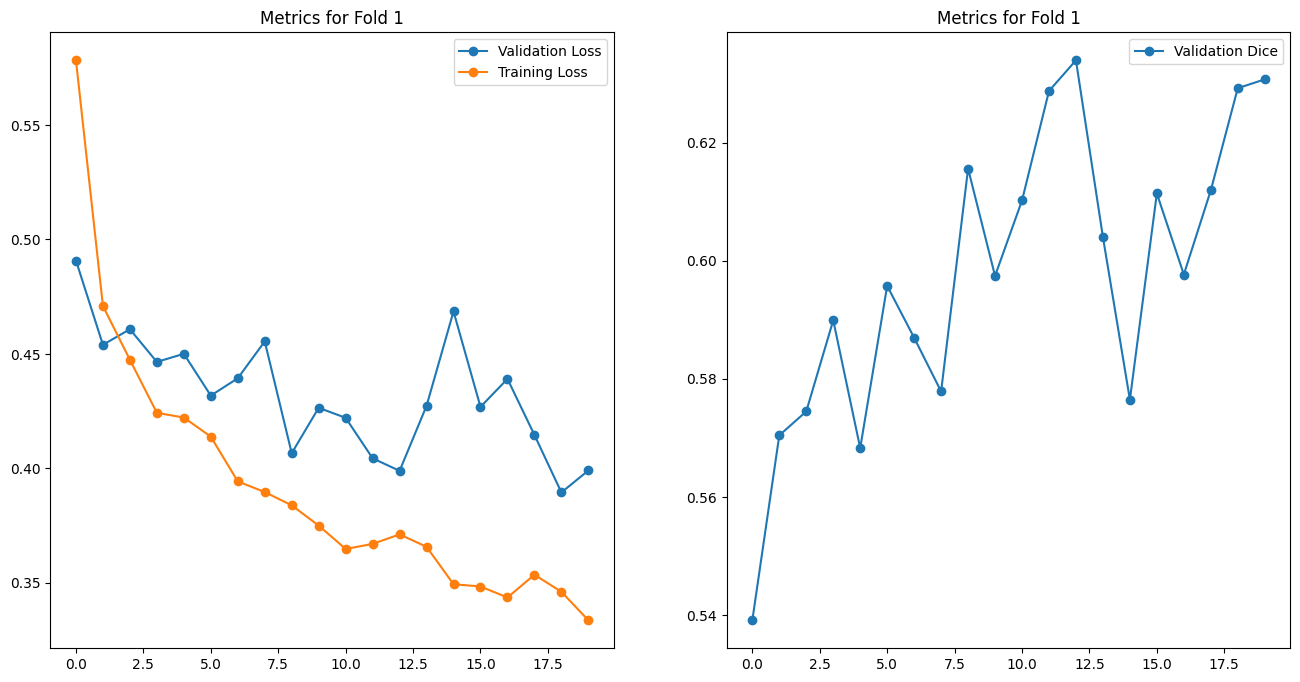

In [8]:
import seaborn as sn
import matplotlib.pyplot as plt

visualize_training_metrics(MODEL_SAVE_PATH, 1)

In [9]:
df = pd.read_csv(f"{BASE_DIR}/data/train_df.csv")
df.head()

id                                        annotations  \
0  0006ff2aa7cd  [{'type': 'glomerulus', 'coordinates': [[[167,...   
1  00168d1b7522  [{'type': 'glomerulus', 'coordinates': [[[511,...   
2  0033bbc76b6b  [{'type': 'blood_vessel', 'coordinates': [[[16...   
3  003504460b3a  [{'type': 'blood_vessel', 'coordinates': [[[40...   
4  004daf1cbe75  [{'type': 'blood_vessel', 'coordinates': [[[14...   

                                                path  kfold  
0  D:/Machine_Learning/hubmap-hacking-the-human-v...      2  
1  D:/Machine_Learning/hubmap-hacking-the-human-v...      4  
2  D:/Machine_Learning/hubmap-hacking-the-human-v...      2  
3  D:/Machine_Learning/hubmap-hacking-the-human-v...      2  
4  D:/Machine_Learning/hubmap-hacking-the-human-v...      3

In [10]:
fold = 0
IMAGE_SIZE = 512
trn_df = df[df.kfold != fold].reset_index(drop=True)
vld_df = df[df.kfold == fold].reset_index(drop=True)

dataset_train = HubMAP_Dataset(trn_df, IMAGE_SIZE, train=True)
dataset_validation = HubMAP_Dataset(vld_df, IMAGE_SIZE, train=False)

c:\Users\pknad\anaconda3\envs\pytorch\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow

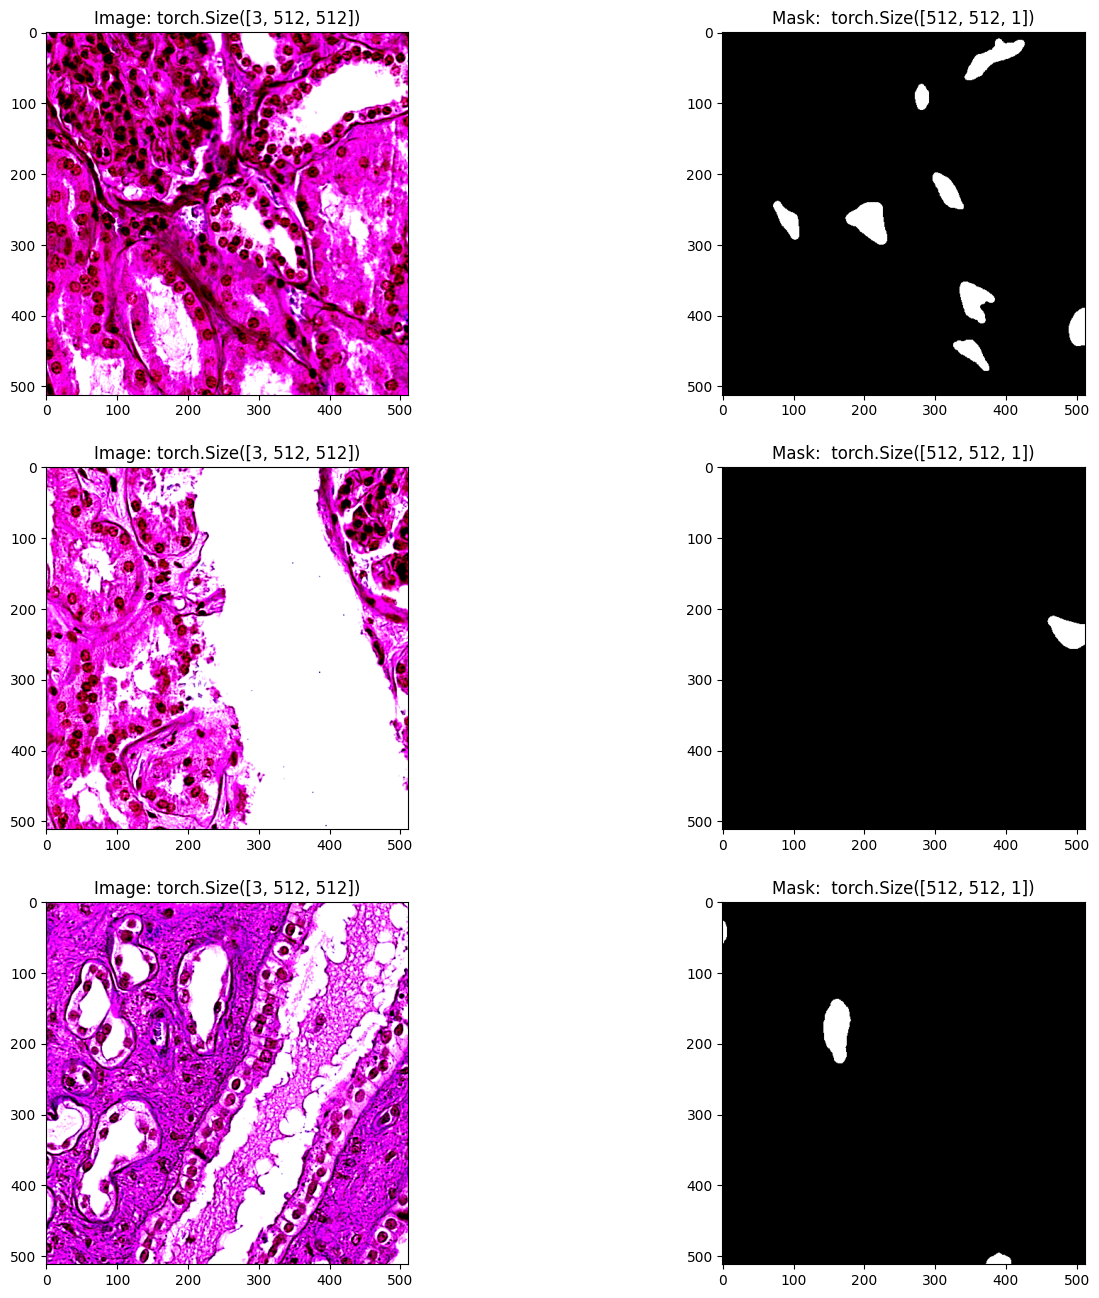

In [11]:
display_dataset(dataset_train, num_examples=3, figsize=(16, 16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


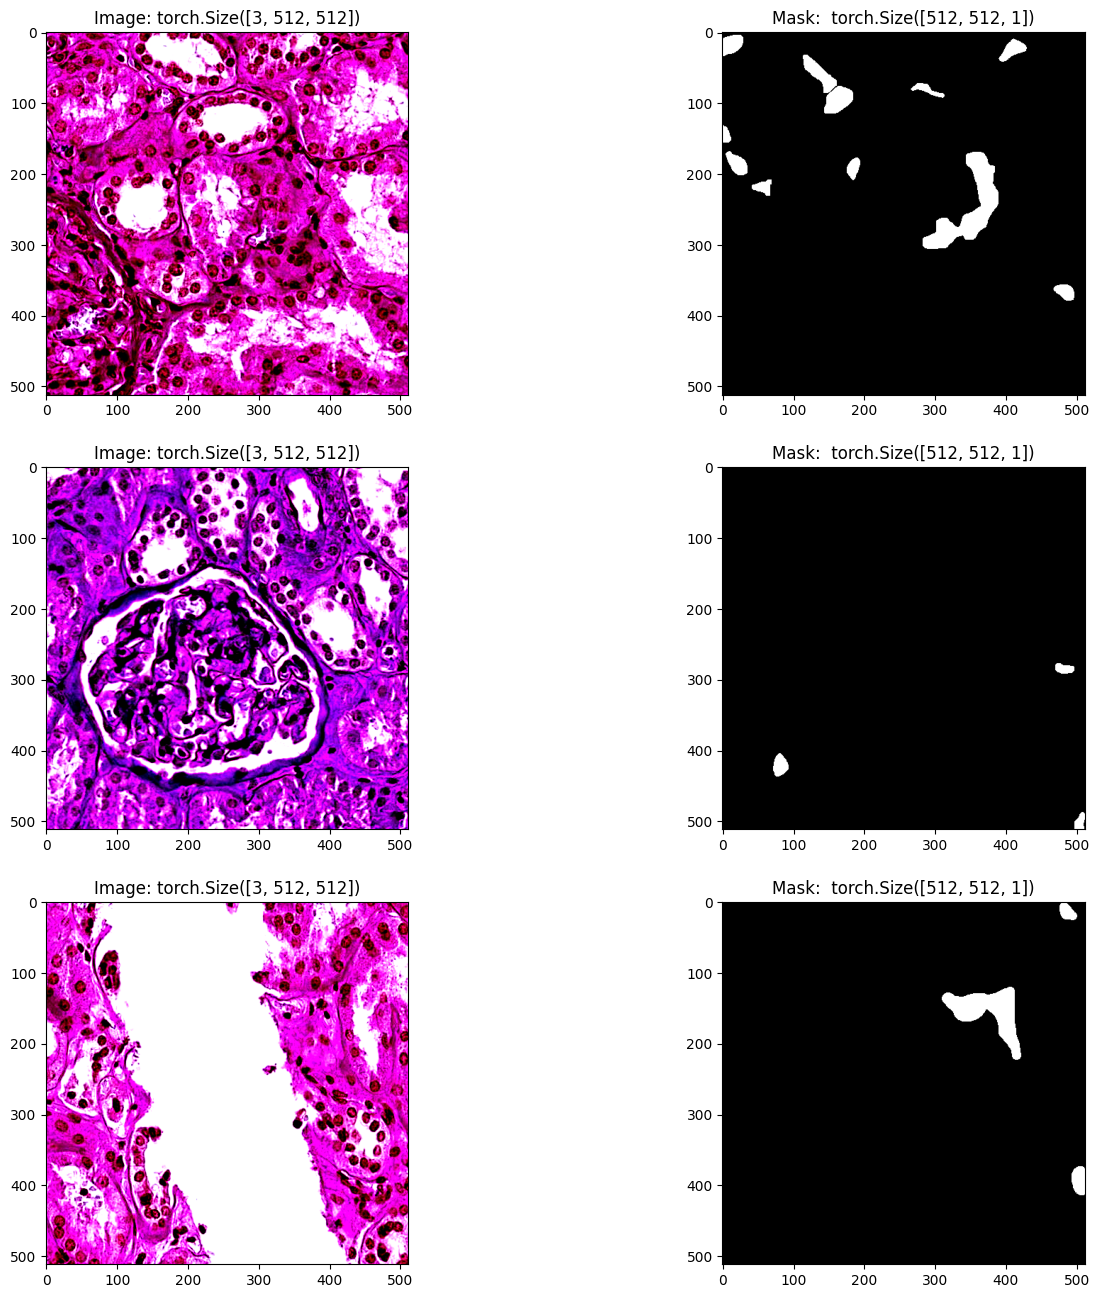

In [12]:
display_dataset(dataset_validation, num_examples=3, figsize=(16, 16))

In [13]:
data_loader_train = DataLoader(
            dataset_train,
            batch_size=8,
            shuffle=False,
            num_workers=1,
        )
data_loader_validation = DataLoader(
    dataset_validation,
    batch_size=8,
    shuffle=False,
    num_workers=1,
)

In [18]:
seg_models = {
    "Unet": smp.Unet,
    "Unet++": smp.UnetPlusPlus,
    "MAnet": smp.MAnet,
    "Linknet": smp.Linknet,
    "FPN": smp.FPN,
    "PSPNet": smp.PSPNet,
    "PAN": smp.PAN,
    "DeepLabV2": smp.DeepLabV3,
    "DeepLabV2+": smp.DeepLabV3Plus,
}


class TestTimeModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.model = seg_models[config["seg_model"]](encoder_name=config["encoder_name"],
                              encoder_weights=None,
                              in_channels=3,
                              classes=1,
                              activation=None,
                              )

    def forward(self, batch):
        return self.model(batch)

In [19]:
model = TestTimeModule(config["model"]).load_from_checkpoint(MODEL_PATH, config=config["model"])
model.to(device)
model.eval()



TestTimeModule(
  (model): UnetPlusPlus(
    (encoder): ResNestEncoder(
      (conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): ResNestBottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (b

In [20]:
all_predictions = []
all_labels = []
all_images = []
dice_scores = []
with torch.no_grad():
    for i, (images, labels) in enumerate(data_loader_validation):
        images = images.to(device)
        labels = labels.to(device)
        targets = labels.clone().detach().long()

        predictions = model(images)
        sigmoid_predictions = torch.sigmoid(predictions)
        dice_score = dice(sigmoid_predictions, targets)

        dice_scores.append(dice_score.item())
        all_images.extend(images.cpu().numpy())
        all_predictions.extend(sigmoid_predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        

KeyboardInterrupt: 

In [21]:
all_predictions = np.transpose(np.array(all_predictions), (0, 2, 3, 1))
all_images = np.transpose(np.array(all_images), (0, 2, 3, 1))
all_labels = np.array(all_labels)

In [22]:
print(all_predictions.shape)
print(all_images.shape)
print(all_labels.shape)

(8, 512, 512, 1)
(8, 512, 512, 3)
(8, 512, 512, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


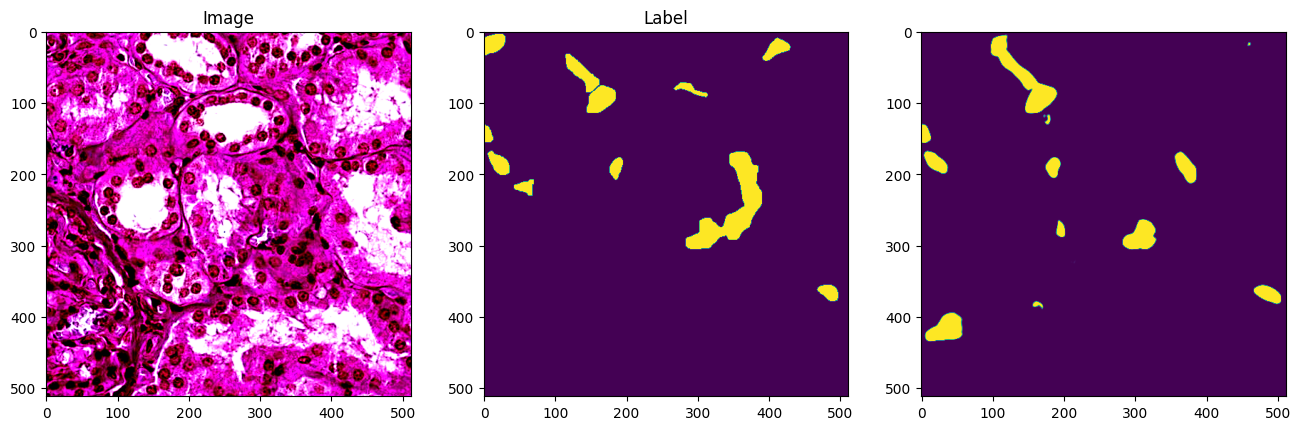

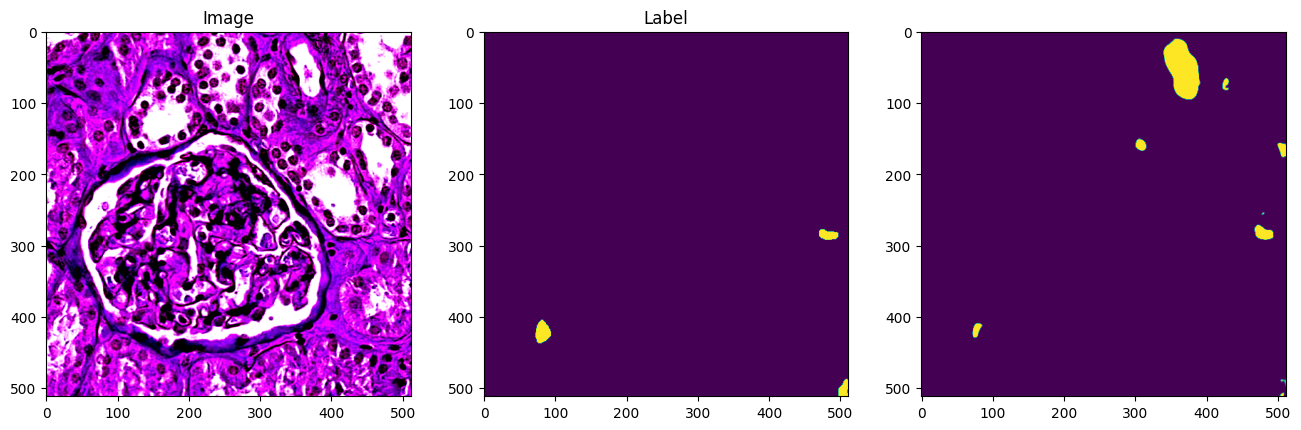

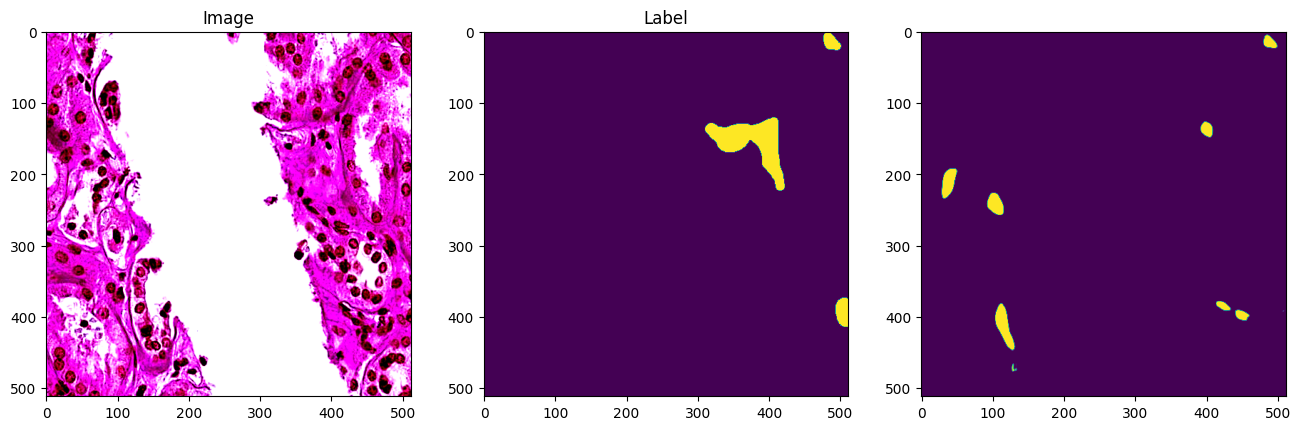

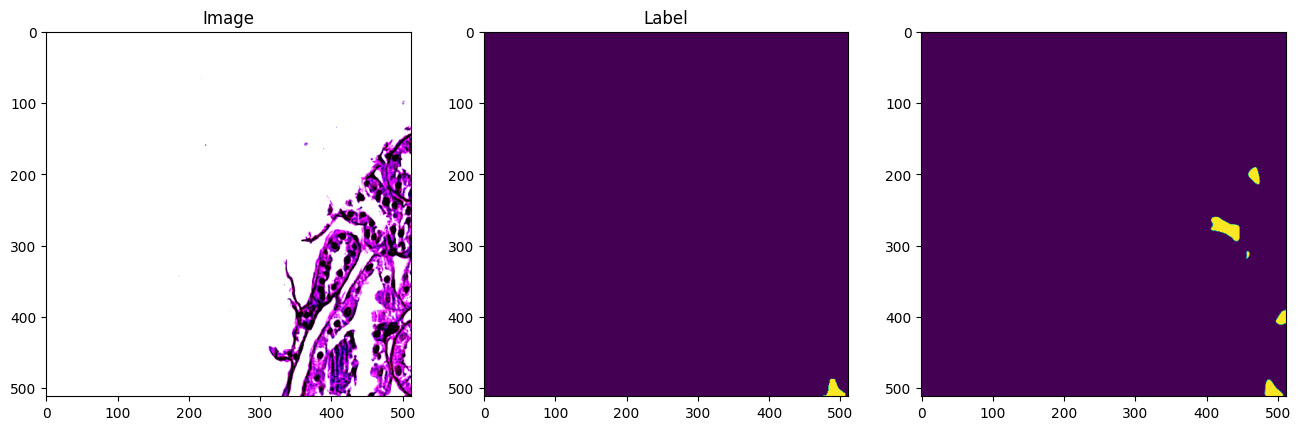

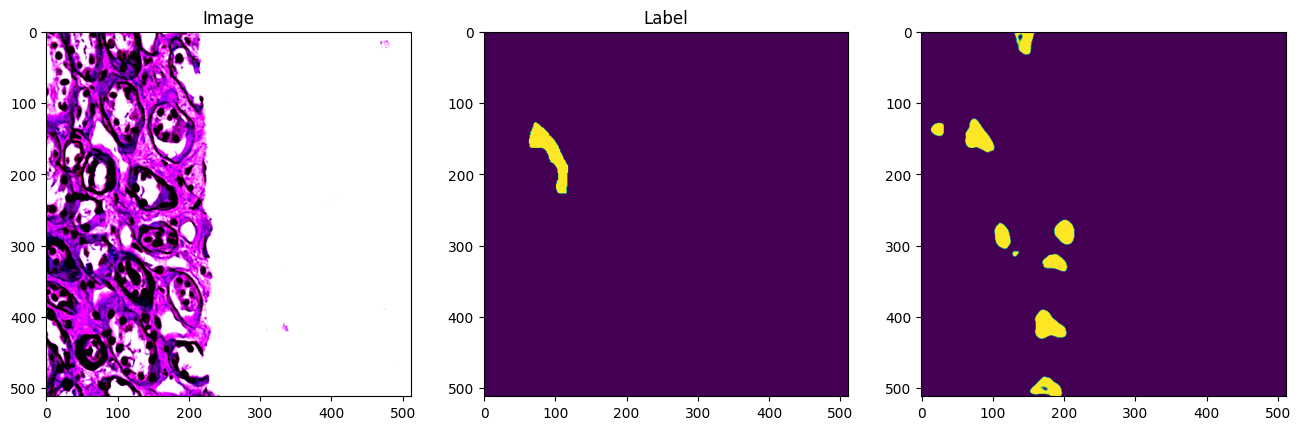

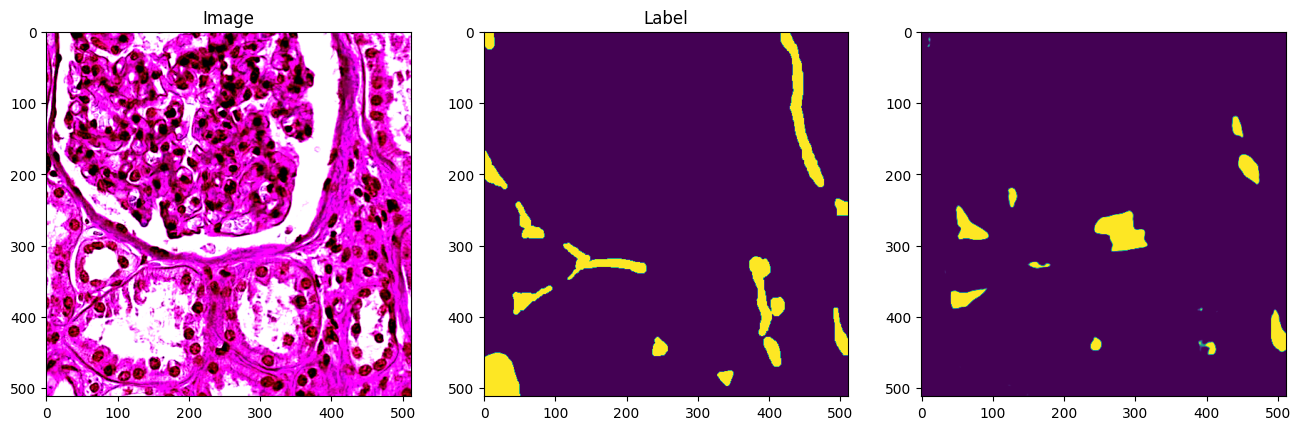

In [27]:
for index in range(0, 6):
    fig, axs = plt.subplots(1, 3, figsize=(16, 8))
    axs[0].imshow(all_images[index])
    axs[0].set_title("Image")
    axs[1].imshow(all_labels[index])
    axs[1].set_title("Label")
    axs[2].imshow(all_predictions[index])
#    axs[2].set_title(f"Prediction {dice_scores[index]}")
